# EDA

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
with open('logins.json', 'r') as file:
    data = json.load(file)
df = pd.DataFrame(data)

In [3]:
df_logins = df.copy()
df_logins.sort_values(by='login_time', ascending=True, inplace=True)
df_logins.reset_index(drop=True, inplace=True)
df_logins.info()
df_logins.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_time  93142 non-null  object
dtypes: object(1)
memory usage: 727.8+ KB


,login_time
0,1970-01-01 20:12:16
1,1970-01-01 20:13:18
2,1970-01-01 20:16:10
3,1970-01-01 20:16:36
4,1970-01-01 20:16:37


In [4]:
df_logins['login_time'] = pd.to_datetime(df_logins['login_time'], format='%Y-%m-%d %H:%M:%S')
df_logins['count'] = 1
df_logins.set_index('login_time', inplace=True)

# count-agg 15 minute windows
login_counts = df_logins.resample('15T').count()

login_counts.head(7)

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
1970-01-01 21:15:00,4
1970-01-01 21:30:00,0


# Initial Visualization

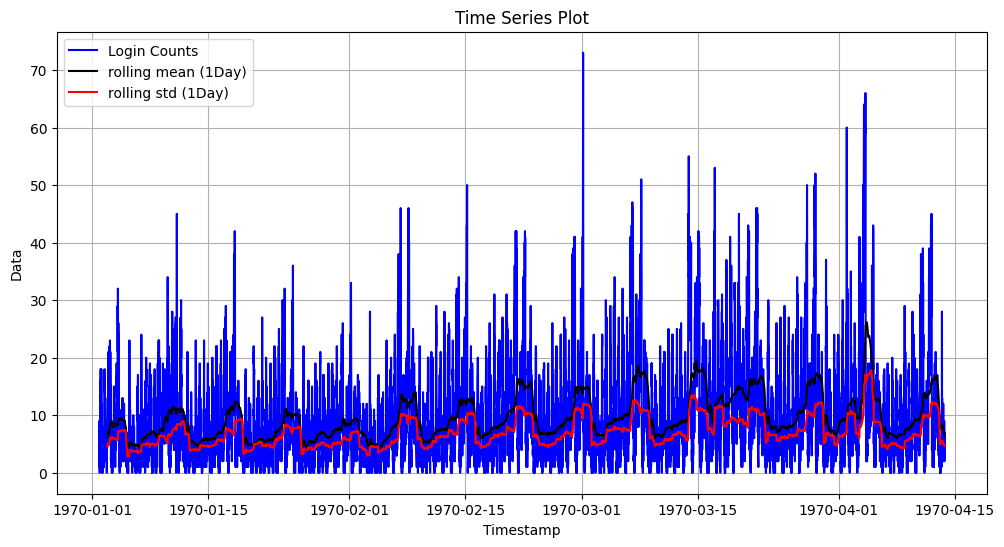

In [5]:
rolling_mean = login_counts.rolling(96).mean()
rolling_std = login_counts.rolling(96).std()

plt.figure(figsize=(12, 6))

plt.plot(login_counts, label='Login Counts', color='b')
plt.plot(rolling_mean, label='rolling mean (1Day)', color='black')
plt.plot(rolling_std, label='rolling std (1Day)', color='red')

plt.xlabel('Timestamp')
plt.ylabel('Data')
plt.title('Time Series Plot')
plt.legend()
plt.grid(True)

In [6]:
from statsmodels.tsa.stattools import adfuller
adft = adfuller(login_counts,autolag="AIC")
adft_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})

In [7]:
adft_df.head()

,Values,Metric
0,-1.033795e+01,Test Statistics
1,2.732397e-18,p-value
2,3.800000e+01,No. of lags used
3,9.749000e+03,Number of observations used
4,-3.431021e+00,critical value (1%)


# Investigate Cyclical Patterns

/var/folders/_w/xxwqncbj69xfsg6qtjh7f1640000gn/T/ipykernel_74261/353300898.py:13: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1.0 / xf, amplitude)


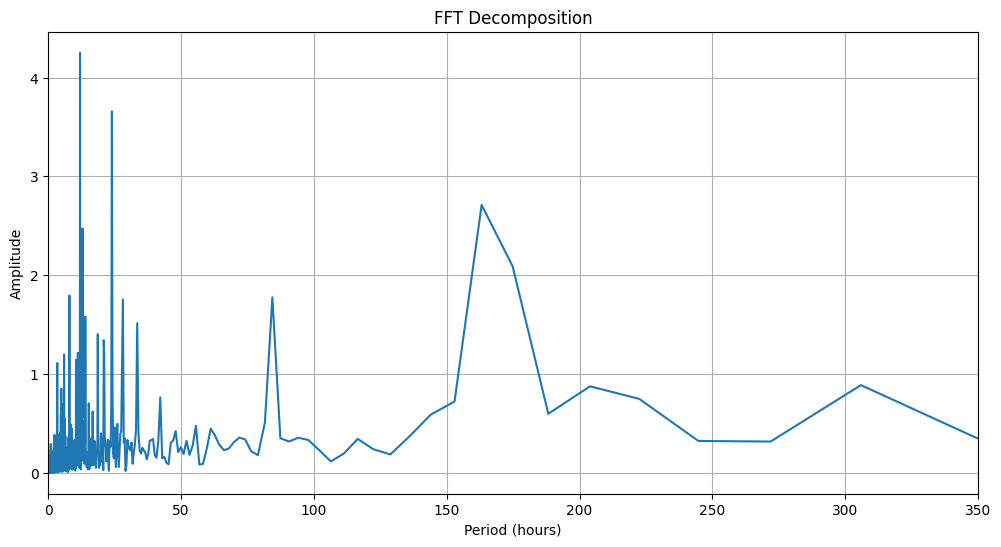

In [8]:
from scipy.fft import fft

y = login_counts['count']
N = len(y)
T = 15 / 60  # 15 minutes to hours
xf = np.fft.fftfreq(N, T)[:N // 2]
yf = fft(y)
amplitude = 2.0 / N * np.abs(yf[:N // 2])

# Fast Fourier Transform
plt.figure(figsize=(12, 6))
plt.xlim((0,350))
plt.plot(1.0 / xf, amplitude)
plt.xlabel('Period (hours)')
plt.ylabel('Amplitude')
plt.title('FFT Decomposition')
plt.grid(True)

## Daily seasonality

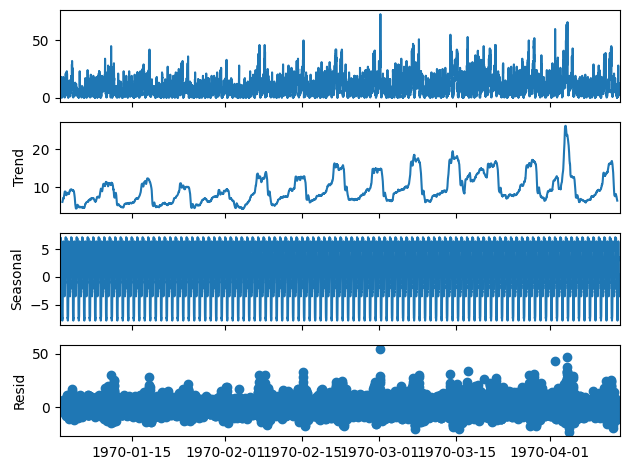

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(login_counts,model='additive', period=96)
decompose.plot()
day = decompose.seasonal[16:112]

Text(0.5, 0, 'Hour')

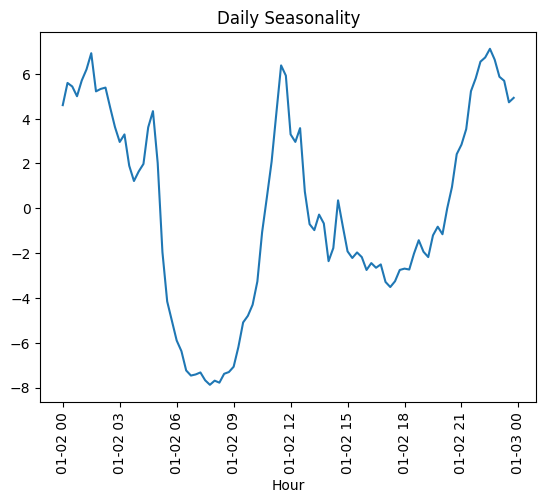

In [10]:
plt.plot(day)
plt.xticks(rotation=90)
plt.title('Daily Seasonality')
plt.xlabel('Hour')

## Weekly seasonality

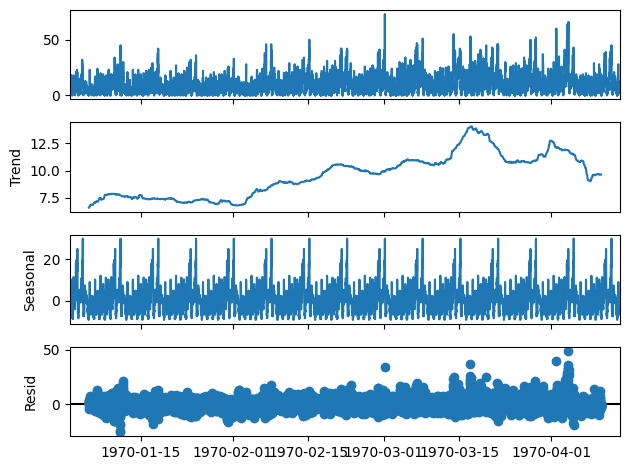

In [11]:
decompose = seasonal_decompose(login_counts,model='additive', period=96*7)
decompose.plot()
week = decompose.seasonal[0:96*7]

Text(0.5, 0, 'Hour')

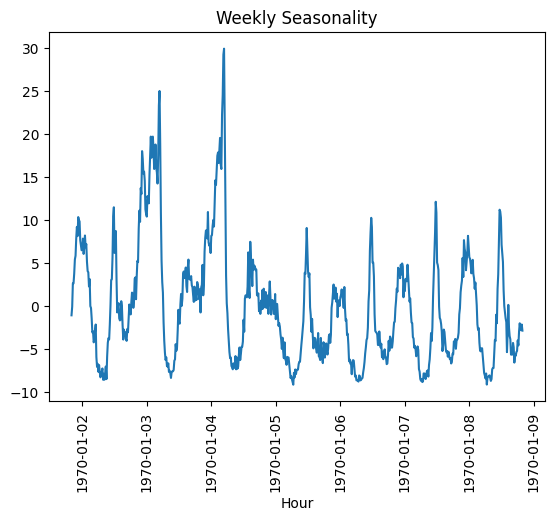

In [12]:
plt.plot(size=(6,3))
plt.plot(week)
plt.xticks(rotation=90)
plt.title('Weekly Seasonality')
plt.xlabel('Hour')